# Day 3 作业--Pixel2Pixel：人像卡通化

经过今天的学习，相信大家对图像翻译、风格迁移有了一定的了解啦，是不是也想自己动手来实现下呢？

那么，为了满足大家动手实践的愿望，同时为了巩固大家学到的知识，我们Day 3的作业便是带大家完成一遍课程讲解过的应用--**Pixel2Pixel：人像卡通化**

在本次作业中，大家需要做的是：**补齐代码，跑通训练，提交一张卡通化的成品图，动手完成自己的第一个人像卡通化的应用~**

![](https://ai-studio-static-online.cdn.bcebos.com/6e3af14bf9f847ab92215753fb3b8f61a66186b538f44da78ca56627c35717b8)

## 准备工作：引入依赖 & 数据准备

In [7]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

### 数据准备：

- 真人数据来自[seeprettyface](http://www.seeprettyface.com/mydataset.html)。（由StyleGAN生成）
- 数据预处理（详情见[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目）。

utils/preprocess.py(包含face_detect.py脸部检测和face_seg.py脸部分割后进行裁剪)
<div>
  <img src='https://ai-studio-static-online.cdn.bcebos.com/c56c889827534363a8b6909d7737a1da64635ad33e1e44cb822f4c1cf1dfc689' height='1000px' width='1000px'>
</div>

- 使用[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目生成真人数据对应的卡通数据。

In [2]:
# 解压数据
!unzip -q data/data79149/cartoon_A2B.zip -d data/

**待解压文件**

![](https://ai-studio-static-online.cdn.bcebos.com/4b61ac42897c41609a7e0bb0ff5bb0c21a92b9880c77485e92fa87b1c0363142)

**解压后文件结构**

![](https://ai-studio-static-online.cdn.bcebos.com/c646d72304b140ed9dad98572a5aad8661ccc06030fa42a7a54892c13be6bd4e)


### 数据可视化

训练集数据量: 1361
测试集数据量: 100


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


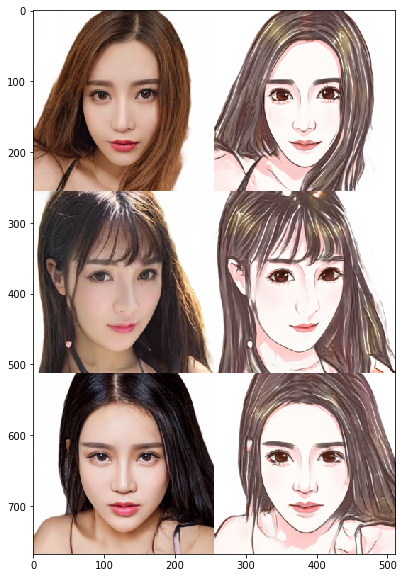

In [3]:
# 训练数据统计
train_names = os.listdir('data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 3, replace=False):#随机挑选3张
    imgs.append(cv2.imread('data/cartoon_A2B/train/'+img_name))

img_show = np.vstack(imgs)[:,:,::-1]#BGR->RGB
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

In [4]:
#获得一组数据（A：真人图片，B：卡通图片）
class PairedData(Dataset):
    def __init__(self, phase):#phase is in ['train','test']
        super(PairedData, self).__init__() 
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 获取样本数量

    def __getitem__(self, idx):
        img_A2B =  cv2.imread(self.img_path_list[idx])    # 读取一组数据
        img_A2B =  img_A2B.astype('float32')/127.5-1      # 从0~255归一化至-1~1 (0,255)/127.5->(0,2)-1->(-1,1)
        img_A2B =  img_A2B.transpose(2,0,1)               # 维度变换HWC -> CHW (H,W,C):(0,1,2)
        
        #一张图片为(255*255)，整张图片宽为255*2，左半部分为真人照，右半部分为卡通照
        img_A =    img_A2B[:,:,:256]                      # 真人照
        img_B =    img_A2B[:,:,256:]                      # 卡通图
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"#确保目录下有train和test文件夹
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = 'data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]#返回所有数据的路径

In [5]:
paired_dataset_train = PairedData('train')#训练集
paired_dataset_test = PairedData('test')#测试集

## 第一步：搭建生成器

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [15]:
class UnetGenerator(nn.Layer):#金字塔结构，先下采样后上采样
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()
        
        #下采样
        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        #上采样
        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x

#下采样层（卷积）
class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
                                # LeakyReLU, leaky=0.2
                                nn.LeakyReLU(0.2),
                                # Conv2D
                                nn.Conv2D(in_dim,out_dim,kernel_size,stride,padding),
                                # BatchNorm2D
                                nn.BatchNorm2D(out_dim)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

#下采样层（转置卷积）
class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
                                # ReLU
                                nn.ReLU(),
                                # Conv2DTranspose
                                nn.Conv2DTranspose(in_dim,out_dim,kernel_size,stride,padding),
                                # nn.BatchNorm2D
                                nn.BatchNorm2D(out_dim)
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    #跳跃连接
    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

## 第二步：鉴别器的搭建

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [16]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
                                # Conv2D
                                nn.Conv2D(in_dim,out_dim,kernel_size,stride,padding),
                                # BatchNorm2D
                                nn.BatchNorm2D(out_dim),
                                # LeakyReLU, leaky=0.2
                                nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [17]:
generator = UnetGenerator()
print(generator)
discriminator = NLayerDiscriminator()
print(discriminator)

UnetGenerator(
  (down1): Conv2D(3, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
  (down2): Downsample(
    (layers): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2D(64, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
      (2): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    )
  )
  (down3): Downsample(
    (layers): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2D(128, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
      (2): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    )
  )
  (down4): Downsample(
    (layers): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2D(256, 512, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
      (2): BatchNorm2D(num_features=512, momentum=0.9, epsilon=1e-05)
    )
  )
  (down5): Downsample(
    (layers): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2D(512

In [18]:
out = generator(paddle.ones([1, 3, 256, 256]))#(bs,C,H,W)
print('生成器输出尺寸：', out.shape)  # 应为[1, 3, 256, 256]

out = discriminator(paddle.ones([1, 6, 256, 256]))#判别器包含生成图和真图，因此通道数为6
print('鉴别器输出尺寸：', out.shape)  # 应为[1, 1, 30, 30] 256->128->64->32->30

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 30, 30]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


In [19]:
# 超参数
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 100

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=discriminator.parameters(), 
    beta1=0.5,
    beta2=0.999)
    
# 损失函数
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE
    )

In [20]:
# 保存每个epoch的测试结果
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  

# 保存模型
weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  

#开始训练
for epoch in range(EPOCHS):
    for data in tqdm(data_loader_train):#进度条
        real_A, real_B = data

        #训练判别器
        optimizerD.clear_grad()
        # D([real_A, real_B])=1
        real_AB = paddle.concat((real_A, real_B), 1)#合并两幅图像
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D([real_A, fake_B])=0
        fake_B = generator(real_A).detach()#训练判别器时冻结生成器
        fake_AB = paddle.concat((real_A,fake_B),1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict,paddle.zeros_like(d_fake_predict))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.#mean loss

        d_loss.backward()
        optimizerD.step()

        #训练生成器
        optimizerG.clear_grad()
        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A,fake_B),1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict,paddle.ones_like(g_fake_predict))
        g_l1_loss = l1_loss(fake_B,real_B)#度量生成图像和真实图像的距离
        g_loss = g_bce_loss + g_l1_loss * 100.#lamda=100
        
        # train G
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    #每隔10轮保存权重
    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()#进入测试模式
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            print(real_A.shape)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)#取前三副图像横向拼接

            result = result.detach().numpy().transpose(0, 2, 3, 1)#(N,H,W,C)
            result = np.vstack(result)#堆叠一组图片
            result = (result * 127.5 + 127.5).astype(np.uint8)#反归一化到(0,255)
    
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)#保存每轮图片

        generator.train()

  0%|          | 0/170 [00:00<?, ?it/s]/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
  1%|          | 1/170 [00:00<00:23,  7.04it/s]

Epoch [1/100] Loss D: [0.48350328], Loss G: [13.52166]


  1%|          | 1/170 [00:00<00:23,  7.09it/s]

Epoch [2/100] Loss D: [0.5675273], Loss G: [12.196893]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch [3/100] Loss D: [0.645354], Loss G: [12.53075]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [4/100] Loss D: [0.48900312], Loss G: [11.407453]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch [5/100] Loss D: [0.5557703], Loss G: [11.271417]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch [6/100] Loss D: [0.79517424], Loss G: [11.564563]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch [7/100] Loss D: [0.5241467], Loss G: [10.234133]


  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch [8/100] Loss D: [0.54350877], Loss G: [9.974571]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch [9/100] Loss D: [0.54325694], Loss G: [9.430177]


100%|██████████| 170/170 [00:23<00:00,  7.37it/s]


Epoch [10/100] Loss D: [0.5919651], Loss G: [10.603699]


  1%|          | 1/170 [00:00<00:29,  5.75it/s]

[8, 3, 256, 256]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [11/100] Loss D: [0.6746067], Loss G: [9.712974]


  1%|          | 1/170 [00:00<00:24,  6.90it/s]

Epoch [12/100] Loss D: [0.62584186], Loss G: [8.642076]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [13/100] Loss D: [0.5772137], Loss G: [8.506796]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch [14/100] Loss D: [0.55331695], Loss G: [8.951698]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [15/100] Loss D: [0.7975823], Loss G: [9.692125]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [16/100] Loss D: [0.65926796], Loss G: [8.386188]


  1%|          | 1/170 [00:00<00:23,  7.15it/s]

Epoch [17/100] Loss D: [0.6348595], Loss G: [8.692898]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [18/100] Loss D: [0.5468286], Loss G: [7.939683]


  1%|          | 1/170 [00:00<00:23,  7.12it/s]

Epoch [19/100] Loss D: [0.6238173], Loss G: [7.8331923]


100%|██████████| 170/170 [00:23<00:00,  7.38it/s]


Epoch [20/100] Loss D: [0.65131277], Loss G: [7.49537]


  1%|          | 1/170 [00:00<00:30,  5.48it/s]

[8, 3, 256, 256]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch [21/100] Loss D: [0.6345581], Loss G: [7.457681]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch [22/100] Loss D: [0.5948945], Loss G: [7.3477783]


  1%|          | 1/170 [00:00<00:24,  6.88it/s]

Epoch [23/100] Loss D: [0.6763013], Loss G: [7.3982162]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [24/100] Loss D: [0.6850033], Loss G: [7.064644]


  1%|          | 1/170 [00:00<00:24,  6.92it/s]

Epoch [25/100] Loss D: [0.6879771], Loss G: [7.6737623]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [26/100] Loss D: [0.67071223], Loss G: [7.2507257]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [27/100] Loss D: [0.6690686], Loss G: [6.7754774]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch [28/100] Loss D: [0.6573656], Loss G: [6.8702044]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch [29/100] Loss D: [0.65462315], Loss G: [7.0177603]


  1%|          | 2/170 [00:00<00:23,  7.00it/s]100%|██████████| 170/170 [00:23<00:00,  7.32it/s]


Epoch [30/100] Loss D: [0.5998385], Loss G: [6.129494]


  2%|▏         | 4/170 [00:00<00:26,  6.29it/s]

[8, 3, 256, 256]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch [31/100] Loss D: [0.6443004], Loss G: [6.4013]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [32/100] Loss D: [0.6776211], Loss G: [6.415012]


  1%|          | 1/170 [00:00<00:24,  6.82it/s]

Epoch [33/100] Loss D: [0.68130255], Loss G: [6.391195]


  1%|          | 1/170 [00:00<00:24,  6.88it/s]

Epoch [34/100] Loss D: [0.65306234], Loss G: [6.1163015]


  1%|          | 1/170 [00:00<00:24,  6.86it/s]

Epoch [35/100] Loss D: [0.65826684], Loss G: [6.322016]


  1%|          | 1/170 [00:00<00:24,  6.89it/s]

Epoch [36/100] Loss D: [0.63732946], Loss G: [5.8925486]


  1%|          | 1/170 [00:00<00:24,  6.85it/s]

Epoch [37/100] Loss D: [0.69163543], Loss G: [6.3605123]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch [38/100] Loss D: [0.5823321], Loss G: [5.907626]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch [39/100] Loss D: [0.6249871], Loss G: [5.653751]


100%|██████████| 170/170 [00:23<00:00,  7.38it/s]


Epoch [40/100] Loss D: [0.62059224], Loss G: [5.6089115]


  5%|▍         | 8/170 [00:01<00:22,  7.20it/s]

[8, 3, 256, 256]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [41/100] Loss D: [0.60553193], Loss G: [6.135261]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch [42/100] Loss D: [0.63929474], Loss G: [5.149466]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch [43/100] Loss D: [0.608804], Loss G: [5.6456356]


  1%|          | 1/170 [00:00<00:23,  7.21it/s]

Epoch [44/100] Loss D: [0.67609936], Loss G: [5.8644543]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [45/100] Loss D: [0.6558421], Loss G: [5.539234]


  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch [46/100] Loss D: [0.6372797], Loss G: [5.465848]


  1%|          | 1/170 [00:00<00:23,  7.12it/s]

Epoch [47/100] Loss D: [0.7213763], Loss G: [5.79729]


  1%|          | 1/170 [00:00<00:23,  7.10it/s]

Epoch [48/100] Loss D: [0.6497109], Loss G: [5.540771]


  1%|          | 1/170 [00:00<00:23,  7.10it/s]

Epoch [49/100] Loss D: [0.64703405], Loss G: [5.370173]


  1%|          | 2/170 [00:00<00:23,  7.19it/s]100%|██████████| 170/170 [00:22<00:00,  7.39it/s]


Epoch [50/100] Loss D: [0.639658], Loss G: [5.014661]


  4%|▍         | 7/170 [00:01<00:23,  7.07it/s]

[8, 3, 256, 256]


  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch [51/100] Loss D: [0.64161986], Loss G: [5.421604]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch [52/100] Loss D: [0.6579137], Loss G: [5.007058]


  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch [53/100] Loss D: [0.6856838], Loss G: [5.230261]


  1%|          | 1/170 [00:00<00:23,  7.08it/s]

Epoch [54/100] Loss D: [0.6452999], Loss G: [5.2065525]


  1%|          | 1/170 [00:00<00:23,  7.08it/s]

Epoch [55/100] Loss D: [0.6354653], Loss G: [4.945433]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [56/100] Loss D: [0.63857585], Loss G: [4.8222723]


  1%|          | 1/170 [00:00<00:23,  7.16it/s]

Epoch [57/100] Loss D: [0.6449962], Loss G: [5.2150645]


  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch [58/100] Loss D: [0.63990307], Loss G: [5.0802655]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch [59/100] Loss D: [0.65134984], Loss G: [5.107402]


100%|██████████| 170/170 [00:22<00:00,  7.40it/s]


Epoch [60/100] Loss D: [0.74447024], Loss G: [4.9111624]


  1%|          | 1/170 [00:00<00:30,  5.56it/s]

[8, 3, 256, 256]


  1%|          | 1/170 [00:00<00:23,  7.12it/s]

Epoch [61/100] Loss D: [0.66844076], Loss G: [4.9446297]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch [62/100] Loss D: [0.6357244], Loss G: [4.84206]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch [63/100] Loss D: [0.64872825], Loss G: [5.03384]


  1%|          | 1/170 [00:00<00:23,  7.12it/s]

Epoch [64/100] Loss D: [0.6762857], Loss G: [4.854898]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [65/100] Loss D: [0.6733311], Loss G: [5.321591]


  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch [66/100] Loss D: [0.62364095], Loss G: [4.782997]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch [67/100] Loss D: [0.632734], Loss G: [4.9105973]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [68/100] Loss D: [0.9787241], Loss G: [4.7653894]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch [69/100] Loss D: [0.644723], Loss G: [4.51443]


  1%|          | 2/170 [00:00<00:23,  7.15it/s]100%|██████████| 170/170 [00:23<00:00,  7.38it/s]


Epoch [70/100] Loss D: [0.6403767], Loss G: [4.857486]


  3%|▎         | 5/170 [00:00<00:24,  6.86it/s]

[8, 3, 256, 256]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch [71/100] Loss D: [0.6420903], Loss G: [4.5206738]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [72/100] Loss D: [0.68201905], Loss G: [4.6730204]


  1%|          | 1/170 [00:00<00:23,  7.13it/s]

Epoch [73/100] Loss D: [2.4015932], Loss G: [5.4749475]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch [74/100] Loss D: [0.6553917], Loss G: [4.492289]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch [75/100] Loss D: [0.6542351], Loss G: [4.573426]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch [76/100] Loss D: [0.67857766], Loss G: [4.6071715]


  1%|          | 1/170 [00:00<00:25,  6.55it/s]

Epoch [77/100] Loss D: [0.63740116], Loss G: [4.5208383]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [78/100] Loss D: [0.6445497], Loss G: [4.6589456]


  1%|          | 1/170 [00:00<00:24,  6.90it/s]

Epoch [79/100] Loss D: [0.6716583], Loss G: [4.752862]


100%|██████████| 170/170 [00:23<00:00,  7.38it/s]


Epoch [80/100] Loss D: [0.65424097], Loss G: [4.268133]


  1%|          | 1/170 [00:00<00:29,  5.79it/s]

[8, 3, 256, 256]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch [81/100] Loss D: [0.6540409], Loss G: [4.098643]


  1%|          | 1/170 [00:00<00:23,  7.11it/s]

Epoch [82/100] Loss D: [0.66742015], Loss G: [4.60361]


  1%|          | 1/170 [00:00<00:23,  7.12it/s]

Epoch [83/100] Loss D: [0.65402275], Loss G: [4.588498]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch [84/100] Loss D: [0.6558373], Loss G: [4.196002]


  1%|          | 1/170 [00:00<00:23,  7.10it/s]

Epoch [85/100] Loss D: [0.65971863], Loss G: [4.4483185]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch [86/100] Loss D: [0.65680856], Loss G: [4.4116993]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch [87/100] Loss D: [0.6889429], Loss G: [4.133011]


  1%|          | 1/170 [00:00<00:23,  7.08it/s]

Epoch [88/100] Loss D: [0.6214031], Loss G: [4.3660083]


  1%|          | 1/170 [00:00<00:23,  7.04it/s]

Epoch [89/100] Loss D: [0.64565223], Loss G: [4.230042]


  1%|          | 2/170 [00:00<00:23,  7.12it/s]100%|██████████| 170/170 [00:23<00:00,  7.37it/s]


Epoch [90/100] Loss D: [0.6645731], Loss G: [4.252957]


  3%|▎         | 5/170 [00:00<00:24,  6.79it/s]

[8, 3, 256, 256]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [91/100] Loss D: [0.6514535], Loss G: [4.3811607]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch [92/100] Loss D: [0.6512061], Loss G: [4.415529]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch [93/100] Loss D: [0.705157], Loss G: [4.7659593]


  1%|          | 1/170 [00:00<00:23,  7.04it/s]

Epoch [94/100] Loss D: [0.6507726], Loss G: [4.4005017]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch [95/100] Loss D: [0.6969359], Loss G: [4.500971]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch [96/100] Loss D: [0.68696916], Loss G: [4.5906787]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch [97/100] Loss D: [0.6446192], Loss G: [4.099448]


  1%|          | 1/170 [00:00<00:24,  6.89it/s]

Epoch [98/100] Loss D: [0.66470075], Loss G: [4.169001]


  1%|          | 1/170 [00:00<00:24,  6.90it/s]

Epoch [99/100] Loss D: [0.6435706], Loss G: [4.0184317]


  1%|          | 2/170 [00:00<00:23,  7.02it/s]100%|██████████| 170/170 [00:23<00:00,  7.38it/s]


Epoch [100/100] Loss D: [0.6765982], Loss G: [4.7601333]
[8, 3, 256, 256]


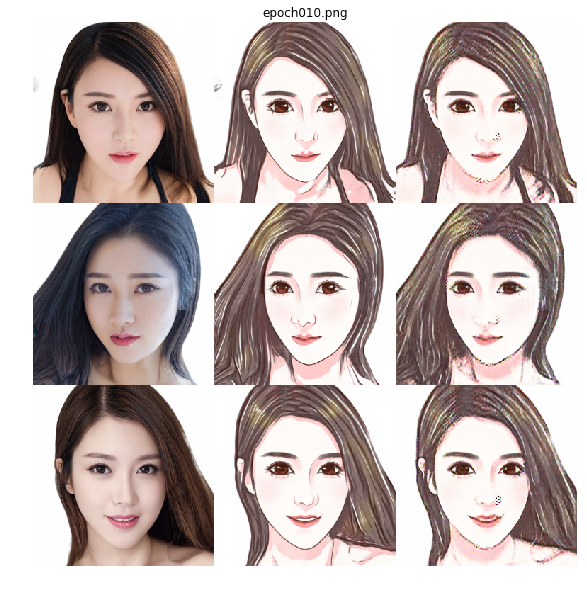

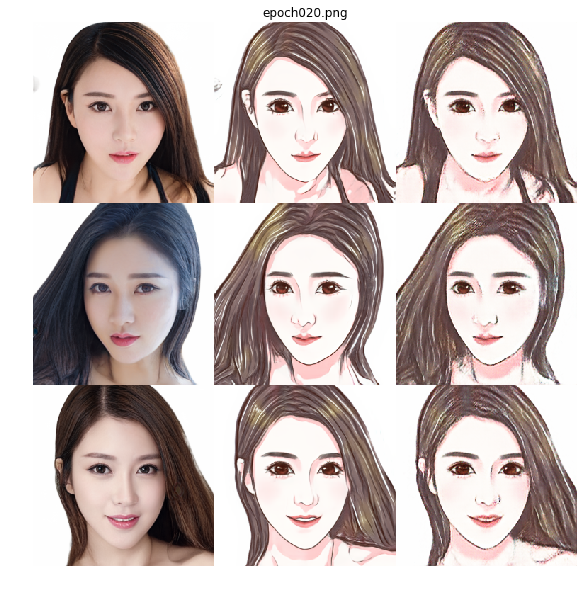

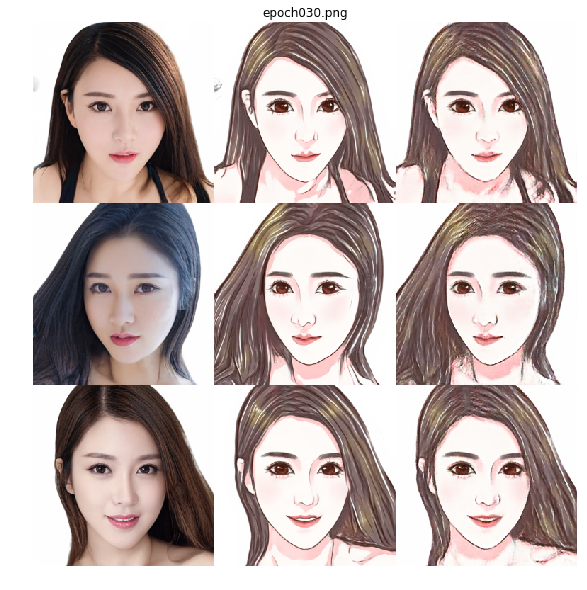

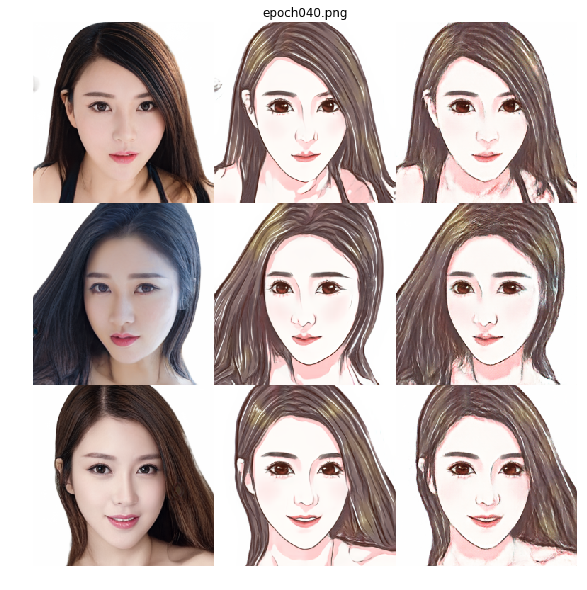

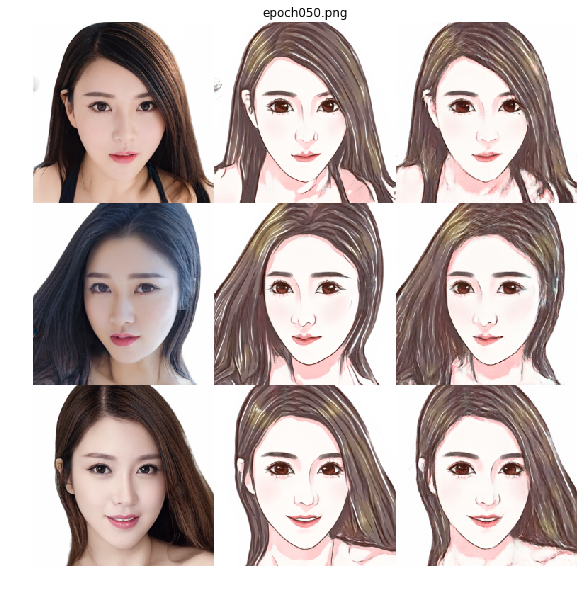

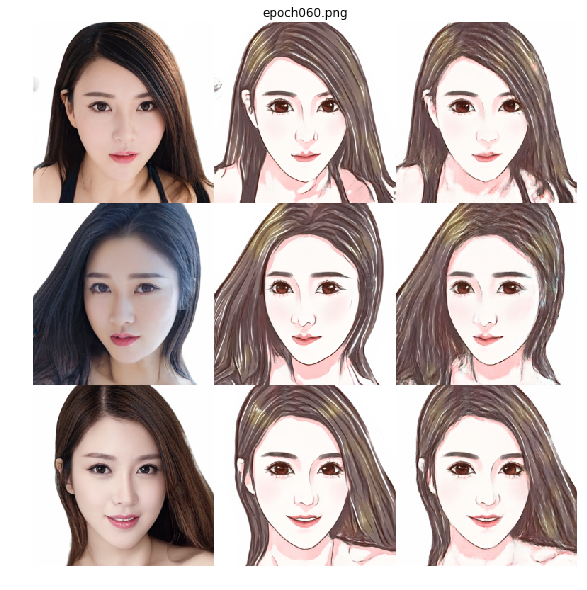

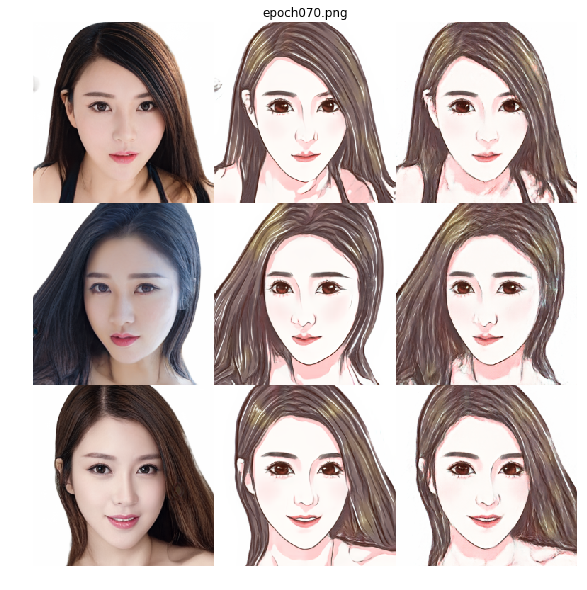

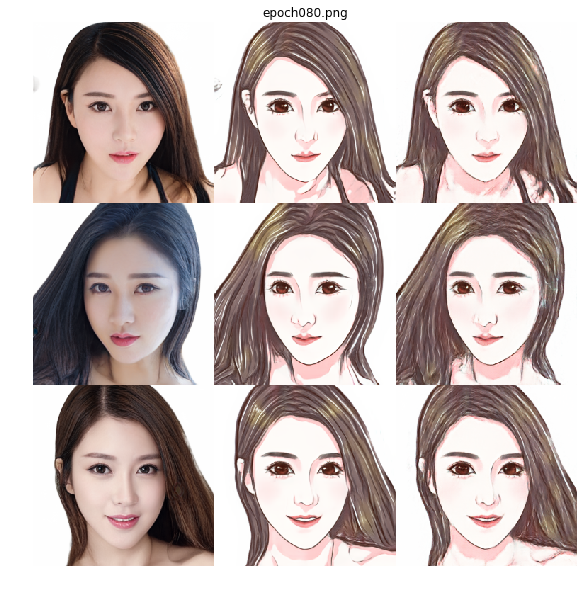

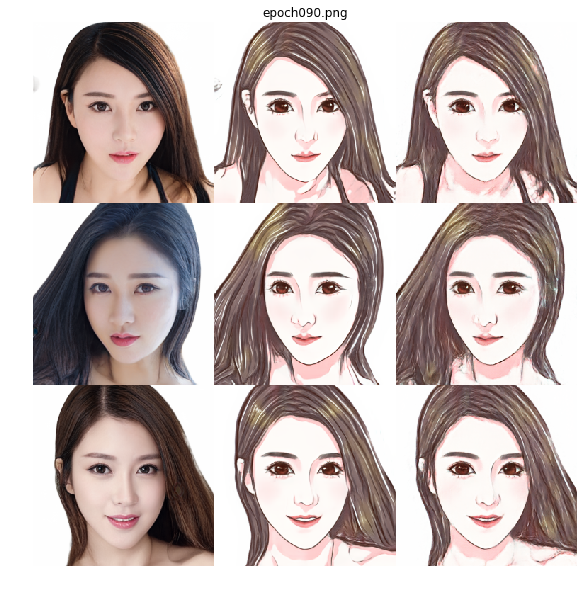

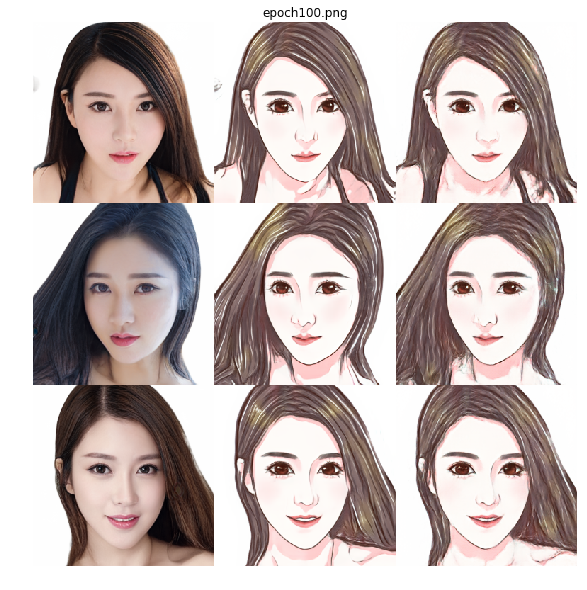

In [32]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

imgs_path='work/results'
for img_path in sorted(os.listdir(imgs_path)):
    img = mpimg.imread(os.path.join(imgs_path,img_path))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_path)
    plt.show()

## 最后：用你补齐的代码试试卡通化的效果吧！

In [33]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])#取迭代次数最大的权重
print('加载权重:', last_weights_path)

#应用权重
model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)

generator.eval()

加载权重: work/weights/epoch100.pdparams


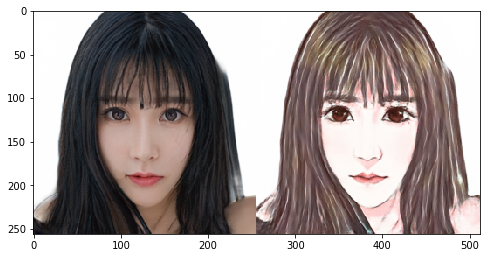

In [34]:
# 读取数据
test_names = os.listdir('data/cartoon_A2B/test')
img_name = np.random.choice(test_names)#随机选取一张图片
img_A2B = cv2.imread('data/cartoon_A2B/test/'+img_name)#读入图片
img_A = img_A2B[:, :256]                                  # 真人照
img_B = img_A2B[:, 256:]                                  # 卡通图

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)                             #生成卡通图
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

#显示图片
img_show = np.hstack([img_A, g_output])[:,:,::-1]#BGR->RGB
plt.figure(figsize=(8, 8))
plt.imshow(img_show)
plt.show()